# Libraries

In [1]:
!pip3 install pyforest

  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14606 sha256=cdbfd823e0662edfa74d2fdaf8dd22dfa89b67443891e77ec8fa976e2ca7d3df
  Stored in directory: /root/.cache/pip/wheels/61/1c/da/48e6c884142d485475d852d69d20a096aba5beceb338822893
Successfully built pyforest


In [2]:
import pyforest
from datetime import datetime
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier, LGBMRegressor

plt.style.use('ggplot')  # стиль для графиков
%matplotlib inline

<IPython.core.display.Javascript object>

# Load Data

In [3]:
train = pd.read_csv('../input/adb-project-1/NPF1_TRAIN.csv', encoding='windows-1251', delimiter=";")
test = pd.read_csv('../input/adb-project-1/NPF1_TEST.csv', delimiter=";")

train = train[train['PRODUCT_LVL_NM13'] == 'Сыры твердые'].copy()
test = test[test['PRODUCT_LVL_NM13'] == 'Сыры твердые'].copy()
train.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,PRODUCT_ID,STORE_LOCATION_ID,period_dt,demand,PRODUCT_LVL_NM8,PRODUCT_LVL_NM13,PRODUCT_DESC,STORE_LOCATION_LVL_NM2,STORE_LOCATION_LVL_NM7,ST_LOC_DIVISION_NM,ST_LOC_MNGMT_CLSTR
2351490,614043,833805,17DEC2018,0.770,Сыры,Сыры твердые,Сыр РОССИЙСКИЙ фас. 1кг,59 ПЕРМСКИЙ КРАЙ,22_1119160 ЛЫСЬВА Г,UR,D_UR17
2351491,614043,833805,18DEC2018,0.346,Сыры,Сыры твердые,Сыр РОССИЙСКИЙ фас. 1кг,59 ПЕРМСКИЙ КРАЙ,22_1119160 ЛЫСЬВА Г,UR,D_UR17
2351492,614043,833805,20DEC2018,0.404,Сыры,Сыры твердые,Сыр РОССИЙСКИЙ фас. 1кг,59 ПЕРМСКИЙ КРАЙ,22_1119160 ЛЫСЬВА Г,UR,D_UR17
2351493,614043,833805,22DEC2018,0.387,Сыры,Сыры твердые,Сыр РОССИЙСКИЙ фас. 1кг,59 ПЕРМСКИЙ КРАЙ,22_1119160 ЛЫСЬВА Г,UR,D_UR17
2351494,614043,833805,24DEC2018,0.302,Сыры,Сыры твердые,Сыр РОССИЙСКИЙ фас. 1кг,59 ПЕРМСКИЙ КРАЙ,22_1119160 ЛЫСЬВА Г,UR,D_UR17


# Data Anlysis

In [4]:
train.dtypes

PRODUCT_ID                  int64
STORE_LOCATION_ID           int64
period_dt                  object
demand                    float64
PRODUCT_LVL_NM8            object
PRODUCT_LVL_NM13           object
PRODUCT_DESC               object
STORE_LOCATION_LVL_NM2     object
STORE_LOCATION_LVL_NM7     object
ST_LOC_DIVISION_NM         object
ST_LOC_MNGMT_CLSTR         object
dtype: object

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378035 entries, 2351490 to 2729524
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   PRODUCT_ID              378035 non-null  int64  
 1   STORE_LOCATION_ID       378035 non-null  int64  
 2   period_dt               378035 non-null  object 
 3   demand                  378035 non-null  float64
 4   PRODUCT_LVL_NM8         378035 non-null  object 
 5   PRODUCT_LVL_NM13        378035 non-null  object 
 6   PRODUCT_DESC            378035 non-null  object 
 7   STORE_LOCATION_LVL_NM2  378035 non-null  object 
 8   STORE_LOCATION_LVL_NM7  378035 non-null  object 
 9   ST_LOC_DIVISION_NM      378035 non-null  object 
 10  ST_LOC_MNGMT_CLSTR      378035 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 34.6+ MB


In [6]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PRODUCT_ID,378035.0,614043.000000,0.000000,614043.00,614043.000,614043.000,614043.000,614043.000
STORE_LOCATION_ID,378035.0,948061.720206,198965.140680,833805.00,837703.000,841842.000,846005.000,1404511.000
demand,378035.0,1.443949,1.473377,-0.53,0.579,1.005,1.807,50.438


In [7]:
train.loc[train['demand'] < 0, 'demand'] = 0
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PRODUCT_ID,378035.0,614043.000000,0.000000,614043.0,614043.000,614043.000,614043.000,614043.000
STORE_LOCATION_ID,378035.0,948061.720206,198965.140680,833805.0,837703.000,841842.000,846005.000,1404511.000
demand,378035.0,1.443964,1.473361,0.0,0.579,1.005,1.807,50.438


In [8]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,4929.0,3.382019e+04,17866.429215,25.0,18789.0,35886.0,47935.0,62022.0
PRODUCT_ID,4929.0,6.140430e+05,0.000000,614043.0,614043.0,614043.0,614043.0,614043.0
STORE_LOCATION_ID,4929.0,1.373488e+06,102426.041357,835025.0,1396932.0,1401575.0,1404250.0,1407173.0
demand,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train.isna().sum()

PRODUCT_ID                0
STORE_LOCATION_ID         0
period_dt                 0
demand                    0
PRODUCT_LVL_NM8           0
PRODUCT_LVL_NM13          0
PRODUCT_DESC              0
STORE_LOCATION_LVL_NM2    0
STORE_LOCATION_LVL_NM7    0
ST_LOC_DIVISION_NM        0
ST_LOC_MNGMT_CLSTR        0
dtype: int64

In [10]:
test.isna().sum()

index                        0
PRODUCT_ID                   0
STORE_LOCATION_ID            0
period_dt                    0
demand                    4929
PRODUCT_LVL_NM8              0
PRODUCT_LVL_NM13             0
PRODUCT_DESC                 0
STORE_LOCATION_LVL_NM2       0
STORE_LOCATION_LVL_NM7       0
ST_LOC_DIVISION_NM           0
ST_LOC_MNGMT_CLSTR           0
dtype: int64

In [11]:
del test['demand']
test.head()

,index,PRODUCT_ID,STORE_LOCATION_ID,period_dt,PRODUCT_LVL_NM8,PRODUCT_LVL_NM13,PRODUCT_DESC,STORE_LOCATION_LVL_NM2,STORE_LOCATION_LVL_NM7,ST_LOC_DIVISION_NM,ST_LOC_MNGMT_CLSTR
25,25,614043,1406099,21JAN2019,Сыры,Сыры твердые,Сыр РОССИЙСКИЙ фас. 1кг,50 МОСКОВСКАЯ ОБЛ,22_1159030 КОРОЛЕВ Г,ZC,D_ZC06
29,29,614043,1400209,21JAN2019,Сыры,Сыры твердые,Сыр РОССИЙСКИЙ фас. 1кг,19 ХАКАСИЯ РЕСП,22_1234579 САЯНОГОРСК Г,SB,D_SB16
37,37,614043,1402562,21JAN2019,Сыры,Сыры твердые,Сыр РОССИЙСКИЙ фас. 1кг,74 ЧЕЛЯБИНСКАЯ ОБЛ,22_1170788 ЧЕЛЯБИНСК Г,UU,D_UU17
84,84,614043,1406240,21JAN2019,Сыры,Сыры твердые,Сыр РОССИЙСКИЙ фас. 1кг,74 ЧЕЛЯБИНСКАЯ ОБЛ,22_1053166 МИАСС Г,UU,D_UU03
95,95,614043,1406477,21JAN2019,Сыры,Сыры твердые,Сыр РОССИЙСКИЙ фас. 1кг,66 СВЕРДЛОВСКАЯ ОБЛ,22_1211190 КАЧКАНАР Г,UR,D_UR28


In [12]:
def get_dropped(df):
    to_drop = []
    for el in df.columns.tolist():
        if len(df[el].unique()) == 1:
            to_drop.append(el)
        print(el)
        print(df[el].unique())
    return to_drop

In [13]:
to_drop = get_dropped(train)

PRODUCT_ID
[614043]
STORE_LOCATION_ID
[ 833805  833807  833808 ... 1403895 1404250 1404511]
period_dt
['17DEC2018' '18DEC2018' '20DEC2018' '22DEC2018' '24DEC2018' '25DEC2018'
 '26DEC2018' '27DEC2018' '28DEC2018' '29DEC2018' '30DEC2018' '06JAN2019'
 '07JAN2019' '10JAN2019' '12JAN2019' '13JAN2019' '14JAN2019' '15JAN2019'
 '16JAN2019' '18JAN2019' '19JAN2019' '20JAN2019' '19DEC2018' '21DEC2018'
 '23DEC2018' '04JAN2019' '05JAN2019' '08JAN2019' '09JAN2019' '11JAN2019'
 '17JAN2019' '31DEC2018' '01JAN2019' '03JAN2019' '02JAN2019']
demand
[ 0.77   0.346  0.404 ...  8.345  8.788 18.328]
PRODUCT_LVL_NM8
['Сыры']
PRODUCT_LVL_NM13
['Сыры твердые']
PRODUCT_DESC
['Сыр РОССИЙСКИЙ фас. 1кг']
STORE_LOCATION_LVL_NM2
['59 ПЕРМСКИЙ КРАЙ' '72 ТЮМЕНСКАЯ ОБЛ' '66 СВЕРДЛОВСКАЯ ОБЛ'
 '74 ЧЕЛЯБИНСКАЯ ОБЛ' '43 КИРОВСКАЯ ОБЛ' '16 ТАТАРСТАН РЕСП'
 '18 УДМУРТСКАЯ РЕСП' '47 ЛЕНИНГРАДСКАЯ ОБЛ' '10 КАРЕЛИЯ РЕСП'
 '35 ВОЛОГОДСКАЯ ОБЛ' '60 ПСКОВСКАЯ ОБЛ' '58 ПЕНЗЕНСКАЯ ОБЛ'
 '63 САМАРСКАЯ ОБЛ' '46 КУРСКАЯ ОБЛ' '50 МОСКОВ

In [14]:
to_drop

['PRODUCT_ID', 'PRODUCT_LVL_NM8', 'PRODUCT_LVL_NM13', 'PRODUCT_DESC']

In [15]:
train.drop(columns=to_drop, inplace=True)
test.drop(columns=to_drop, inplace=True)

In [16]:
def transform_date(df):
    df['date_'] = df['period_dt'].apply(lambda x : datetime.strptime(x, '%d%b%Y').date())

    df['day_of_week'] =df['date_'].apply(lambda x : x.weekday())

transform_date(train)
transform_date(test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

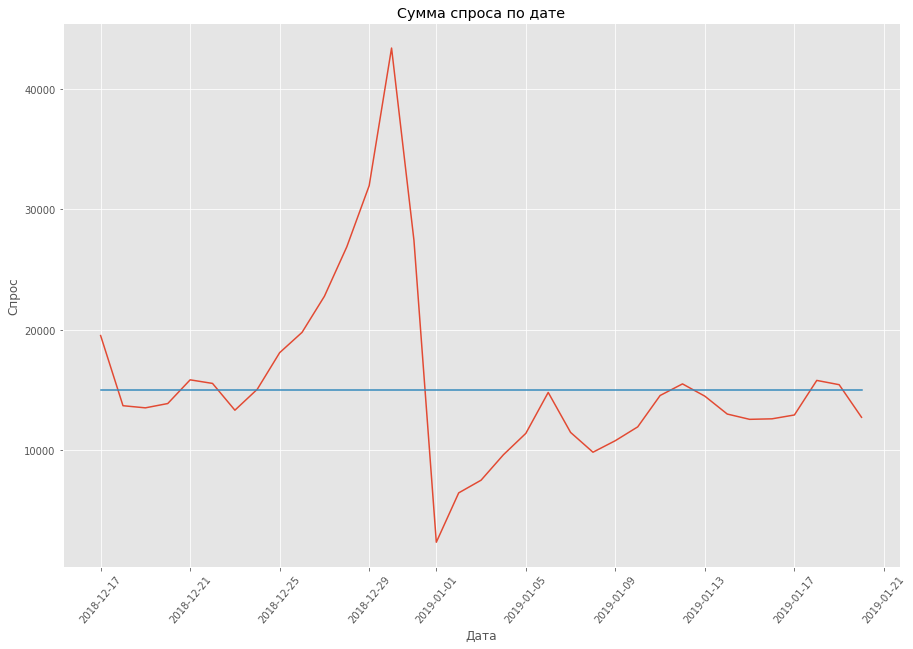

In [17]:
support = train.groupby(['date_']).sum()
support['date_'] = support.index
plt.figure(figsize=(15, 10))
plt.plot(support['date_'], support['demand'])
plt.plot(support['date_'], [15000 for _ in range(support['date_'].shape[0])])
labels = plt.xticks(rotation=50)
plt.ylabel('Спрос')
plt.xlabel('Дата')
_ = plt.title('Сумма спроса по дате')

In [18]:
sup = train[['STORE_LOCATION_ID', 'date_']].groupby('STORE_LOCATION_ID').min() 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Минимальная дата продажи для каждого магазина')

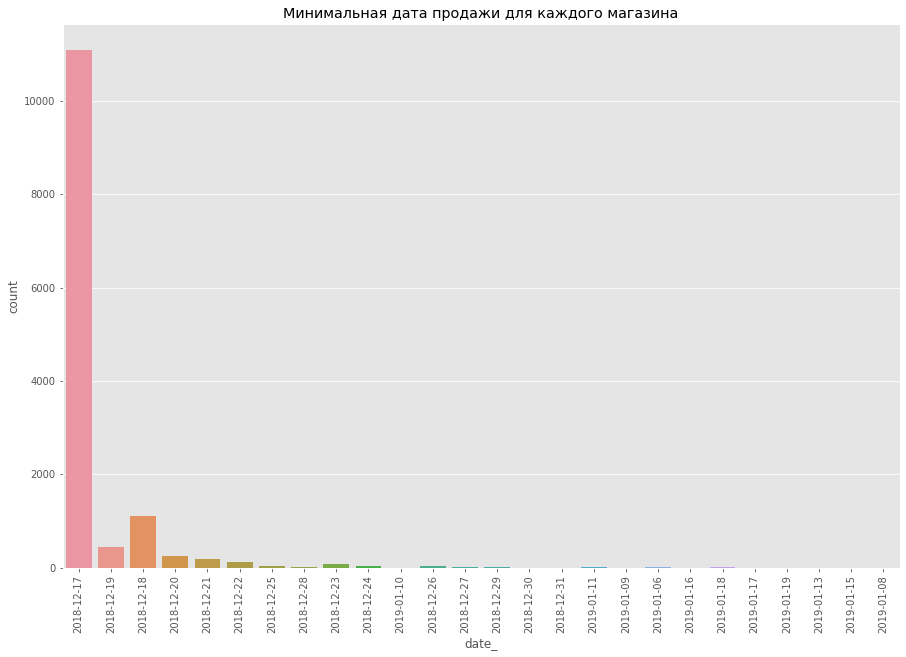

In [19]:
plt.figure(figsize=(15,10))
ax = sns.countplot(sup['date_'])
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Минимальная дата продажи для каждого магазина')

In [20]:
sup = train[['STORE_LOCATION_ID', 'date_']].groupby('STORE_LOCATION_ID').min() 
tmp = dict(zip(sup.index.tolist(), sup['date_'].values.tolist()))
def transe(x, sup):
    if sup[x] >= datetime(2018, 12, 18, 0, 0, 0).date():
        return 1
    else:
        return 0

In [21]:
train['take'] = train['STORE_LOCATION_ID'].apply(transe, args=[tmp])

In [22]:
train = train[train['take'] == 1].copy()
train

,STORE_LOCATION_ID,period_dt,demand,STORE_LOCATION_LVL_NM2,STORE_LOCATION_LVL_NM7,ST_LOC_DIVISION_NM,ST_LOC_MNGMT_CLSTR,date_,day_of_week,take
2352175,833839,19DEC2018,0.577,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-19,2,1
2352176,833839,21DEC2018,0.613,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-21,4,1
2352177,833839,22DEC2018,1.213,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-22,5,1
2352178,833839,23DEC2018,0.385,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-23,6,1
2352179,833839,24DEC2018,0.530,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-24,0,1
...,...,...,...,...,...,...,...,...,...,...
2729520,1404250,18JAN2019,18.328,42 КЕМЕРОВСКАЯ ОБЛ,22_1184635 НОВОКУЗНЕЦК Г,SB,D_SB05,2019-01-18,4,1
2729521,1404250,19JAN2019,8.492,42 КЕМЕРОВСКАЯ ОБЛ,22_1184635 НОВОКУЗНЕЦК Г,SB,D_SB05,2019-01-19,5,1
2729522,1404250,20JAN2019,5.006,42 КЕМЕРОВСКАЯ ОБЛ,22_1184635 НОВОКУЗНЕЦК Г,SB,D_SB05,2019-01-20,6,1
2729523,1404511,18JAN2019,4.225,76 ЯРОСЛАВСКАЯ ОБЛ,22_1090629 ПЕРЕСЛАВСКИЙ Р-Н,NV,D_NV20,2019-01-18,4,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

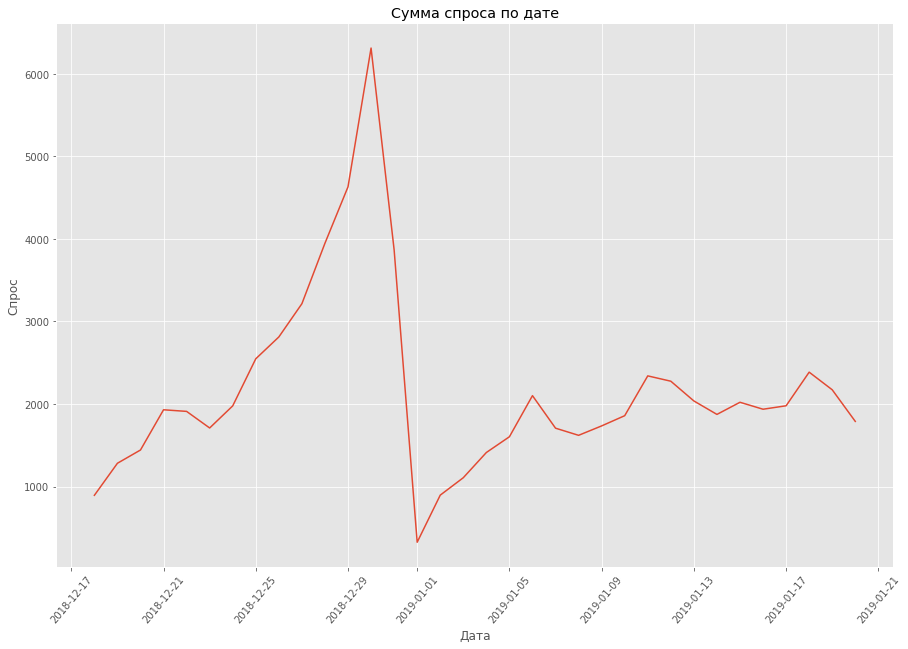

In [23]:
del train['take']
support = train.groupby(['date_']).sum()
support['date_'] = support.index
plt.figure(figsize=(15, 10))
plt.plot(support['date_'], support['demand'])
# plt.plot(support['date_'], [15000 for _ in range(support['date_'].shape[0])])
labels = plt.xticks(rotation=50)
plt.ylabel('Спрос')
plt.xlabel('Дата')
_ = plt.title('Сумма спроса по дате')

In [24]:
train = train[(train.date_ < datetime(2018, 12, 25, 0, 0).date()) | (train.date_ > datetime(2019, 1, 5, 0, 0).date())].copy()
train

,STORE_LOCATION_ID,period_dt,demand,STORE_LOCATION_LVL_NM2,STORE_LOCATION_LVL_NM7,ST_LOC_DIVISION_NM,ST_LOC_MNGMT_CLSTR,date_,day_of_week
2352175,833839,19DEC2018,0.577,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-19,2
2352176,833839,21DEC2018,0.613,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-21,4
2352177,833839,22DEC2018,1.213,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-22,5
2352178,833839,23DEC2018,0.385,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-23,6
2352179,833839,24DEC2018,0.530,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-24,0
...,...,...,...,...,...,...,...,...,...
2729520,1404250,18JAN2019,18.328,42 КЕМЕРОВСКАЯ ОБЛ,22_1184635 НОВОКУЗНЕЦК Г,SB,D_SB05,2019-01-18,4
2729521,1404250,19JAN2019,8.492,42 КЕМЕРОВСКАЯ ОБЛ,22_1184635 НОВОКУЗНЕЦК Г,SB,D_SB05,2019-01-19,5
2729522,1404250,20JAN2019,5.006,42 КЕМЕРОВСКАЯ ОБЛ,22_1184635 НОВОКУЗНЕЦК Г,SB,D_SB05,2019-01-20,6
2729523,1404511,18JAN2019,4.225,76 ЯРОСЛАВСКАЯ ОБЛ,22_1090629 ПЕРЕСЛАВСКИЙ Р-Н,NV,D_NV20,2019-01-18,4


<IPython.core.display.Javascript object>

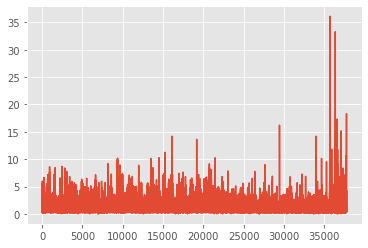

In [25]:
target = train['demand']
_ = plt.plot([i for i in range(target.shape[0])], target)

In [26]:
train = train[train['demand'] <= 20].copy()

In [27]:
train

,STORE_LOCATION_ID,period_dt,demand,STORE_LOCATION_LVL_NM2,STORE_LOCATION_LVL_NM7,ST_LOC_DIVISION_NM,ST_LOC_MNGMT_CLSTR,date_,day_of_week
2352175,833839,19DEC2018,0.577,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-19,2
2352176,833839,21DEC2018,0.613,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-21,4
2352177,833839,22DEC2018,1.213,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-22,5
2352178,833839,23DEC2018,0.385,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-23,6
2352179,833839,24DEC2018,0.530,35 ВОЛОГОДСКАЯ ОБЛ,22_1064048 ВОЛОГДА Г,NV,D_NV03,2018-12-24,0
...,...,...,...,...,...,...,...,...,...
2729520,1404250,18JAN2019,18.328,42 КЕМЕРОВСКАЯ ОБЛ,22_1184635 НОВОКУЗНЕЦК Г,SB,D_SB05,2019-01-18,4
2729521,1404250,19JAN2019,8.492,42 КЕМЕРОВСКАЯ ОБЛ,22_1184635 НОВОКУЗНЕЦК Г,SB,D_SB05,2019-01-19,5
2729522,1404250,20JAN2019,5.006,42 КЕМЕРОВСКАЯ ОБЛ,22_1184635 НОВОКУЗНЕЦК Г,SB,D_SB05,2019-01-20,6
2729523,1404511,18JAN2019,4.225,76 ЯРОСЛАВСКАЯ ОБЛ,22_1090629 ПЕРЕСЛАВСКИЙ Р-Н,NV,D_NV20,2019-01-18,4


# Modeling

In [28]:
del train['period_dt']
del test['period_dt']

del train['date_']
del test['date_']

target = train['demand']
del train['demand']

numeric = train.dtypes[train.dtypes != 'object'].index.tolist()
print(numeric)

categorical = train.dtypes[train.dtypes == 'object'].index.tolist()
print(categorical)

categorical = train.columns.tolist()
print(categorical)

['STORE_LOCATION_ID', 'day_of_week']
['STORE_LOCATION_LVL_NM2', 'STORE_LOCATION_LVL_NM7', 'ST_LOC_DIVISION_NM', 'ST_LOC_MNGMT_CLSTR']
['STORE_LOCATION_ID', 'STORE_LOCATION_LVL_NM2', 'STORE_LOCATION_LVL_NM7', 'ST_LOC_DIVISION_NM', 'ST_LOC_MNGMT_CLSTR', 'day_of_week']


In [29]:
target_class = (target >= 1).astype(int)

In [30]:
del test['index']

In [31]:
encoder = TargetEncoder(cols=categorical)
#numeric
train_cat = encoder.fit_transform(train, target_class).copy()
test_cat = encoder.transform(test).copy()

train = encoder.fit_transform(train, target).copy()
test = encoder.transform(test).copy()

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [32]:
clf = LGBMClassifier().fit(train_cat, target_class)
y_proba = clf.predict_proba(test_cat)


model = LGBMRegressor().fit(train, target)
y_pred = model.predict(test)


y_pred[(y_proba[:,1] <= 0.64)] = 0

submit = pd.read_csv('../input/adb-project-1/sample_ch.csv')

submit['demand'] = y_pred * y_proba[:,1]
submit

<IPython.core.display.Javascript object>

,index,demand
0,25,0.000000
1,29,0.000000
2,37,0.000000
3,84,0.000000
4,95,0.000000
...,...,...
4924,61934,0.000000
4925,61967,0.000000
4926,61973,0.000000
4927,62017,0.000000


In [33]:
submit

,index,demand
0,25,0.000000
1,29,0.000000
2,37,0.000000
3,84,0.000000
4,95,0.000000
...,...,...
4924,61934,0.000000
4925,61967,0.000000
4926,61973,0.000000
4927,62017,0.000000


In [34]:
np.count_nonzero(y_pred > 0)

<IPython.core.display.Javascript object>

521

In [35]:
submit.to_csv("LGBM_10.csv", index = False)